Задание 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.<br><br>
Задание 2. (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.<br><br>
Задание 3.(опция). Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GBDTR:
    
    def __init__(self,
                 n_trees: int=10,
                 max_depth: int=3,
                 lr: float=1e-2,
                 coef: float=1.0):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.lr = lr
        self.coefs = [coef for i in range(self.n_trees)]
        
        
    def predict(self, X) -> np.array:
        
        result = []
        for observation in X:
            
            sub_result = []
            
            for tree in range(len(self.trees)):
                
                tree_pred = self.trees[tree].predict(np.array(observation).reshape((1, 10)))
                sub_result.append(tree_pred[0] * self.lr * self.coefs[tree])
                
            prediction = sum(sub_result)
            result.append(prediction)
            
        return np.array(result)
    
    
    def save_errors(self, X_train, X_test, y_train, y_test):
        
        self.train_errors.append(self.get_mse(y_train, self.predict(X_train)))
        self.test_errors.append(self.get_mse(y_test, self.predict(X_test)))
        
    
    def fit(self, X_train, X_test, y_train, y_test):
        
        self.trees = []
        self.train_errors = []
        self.test_errors = []

        for tree in range(self.n_trees):
            
            dtr = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            
            if len(self.trees) == 0:
                
                dtr.fit(X_train, y_train)
                
            else:
                
                target = self.predict(X_train)
                dtr.fit(X_train, self.bias(y_train, target))
                
            self.save_errors(X_train, X_test, y_train, y_test)
            self.trees.append(dtr)

        return self.train_errors, self.test_errors
    
    
    def get_mse(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    
    def bias(self, y, z):
        return (y - z)

In [3]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = GBDTR()
model.fit(X_train, X_test, y_train, y_test)
a = model.predict(X_test)

In [4]:
# Задание 1. Для реализованной в методичке модели градиентного бустинга 
# построить графики зависимости ошибки от 
# количества деревьев в ансамбле и от максимальной глубины деревьев.
# Сделать выводы о зависимости ошибки от этих параметров.

# Операция длится около получаса. На всякий случай скрин графика прикрепил ниже.
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
trees = [10, 20, 40, 80, 160]
depths = [i for i in range(1, 6)]

train_err = []
test_err = []
for depth in depths:
    train = []
    test = []
    for tree in trees:
        model = GBDTR(n_trees=tree, max_depth=depth)
        model.fit(X_train, X_test, y_train, y_test)
        train.append(min(model.train_errors))
        test.append(min(model.test_errors))
    train_err.append(train)
    test_err.append(test) 

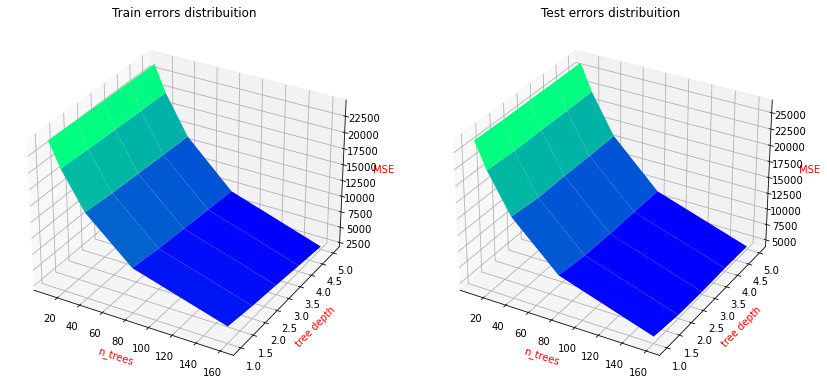

In [5]:
x = np.array(trees)
y = np.array(depths)
X1,Y1 = np.meshgrid(x,y)
Z1 = np.array(train_err)

X2,Y2 = np.meshgrid(x,y)
Z2 = np.array(test_err)


fig = plt.figure(figsize=[14, 7])

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.plot_surface(X1, Y1, Z1,cmap='winter', edgecolor='none')
ax.set_title('Train errors distribuition')
ax.set_xlabel('n_trees', c='r')
ax.set_ylabel('tree depth', c='r')
ax.set_zlabel('MSE', c='r')

ax1 = fig.add_subplot(1, 2, 2, projection='3d')
ax1.plot_surface(X2, Y2, Z2,cmap='winter', edgecolor='none')
ax1.set_title('Test errors distribuition')
ax1.set_xlabel('n_trees', c='r')
ax1.set_ylabel('tree depth', c='r')
ax1.set_zlabel('MSE', c='r')

plt.show()

Из графиков видно, что с увеличением глубины дерева и ростом количества деревьев в бустинге ошибка уменьшаяется и при 160 деревьях с глубиной 5 она практически обнуляется. Если сравнить оба графика, то можно сделать вывод, оптимальную ошибку дадут примерно 155 деревьев с глубиной 3, так как изменение ошибки на тестовой выборке имеет более гладкий характер.

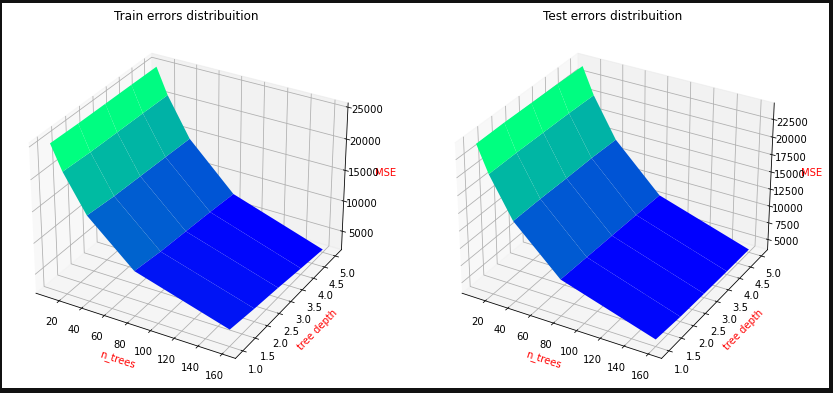

In [6]:
# Задание 2. (опция) . Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг.
# Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

class StochGBDTR:
    
    def __init__(self,
                 n_trees: int=10,
                 max_depth: int=3,
                 lr: float=1e-2,
                 coef: float=1.0,
                 size: float=0.5):
        
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.lr = lr
        self.coefs = [coef for i in range(self.n_trees)]
        self.size = size
        
        
    def predict(self, X) -> np.array:
        
        result = []
        for observation in X:
            
            sub_result = []
            
            for tree in range(len(self.trees)):
                
                tree_pred = self.trees[tree].predict(np.array(observation).reshape((1, 10)))
                sub_result.append(tree_pred[0] * self.lr * self.coefs[tree])
                
            prediction = sum(sub_result)
            result.append(prediction)
            
        return np.array(result)
    
    
    def save_errors(self, X_train, X_test, y_train, y_test):
        
        self.train_errors.append(self.get_mse(y_train, self.predict(X_train)))
        self.test_errors.append(self.get_mse(y_test, self.predict(X_test)))
        
    
    def fit(self, X, y):
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        self.trees = []
        self.train_errors = []
        self.test_errors = []
        size_ = int(X_train.shape[0] * self.size)

        for tree in range(self.n_trees):
            
            dtr = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            
            if len(self.trees) == 0:
                np.random.seed(np.random.choice((100)))
                order = np.arange(X_train.shape[0])
                np.random.shuffle(order)
                
                new_x_train = X_train[order[:size_]]
                new_y_train = y_train[order[:size_]]
                
                dtr.fit(new_x_train, new_y_train)
                
            else:
                np.random.seed(np.random.choice((100)))
                order = np.arange(X_train.shape[0])
                np.random.shuffle(order)
                
                new_x_train = X_train[order[:size_]]
                new_y_train = y_train[order[:size_]]
                                
                target = self.predict(new_x_train)
                dtr.fit(new_x_train, self.bias(new_y_train, target))
                
            self.save_errors(X_train, X_test, y_train, y_test)
            self.trees.append(dtr)
    
    
    def get_mse(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    
    def bias(self, y, z):
        return (y - z)

In [7]:
X, y = load_diabetes(return_X_y=True)
model2 = StochGBDTR(n_trees=100)
model2.fit(X, y)

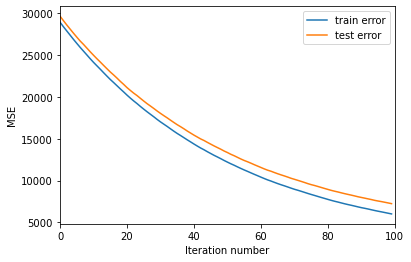

In [8]:
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(0, len(model2.trees))
plt.plot(list(range(model2.n_trees)), model2.train_errors, label='train error')
plt.plot(list(range(model2.n_trees)), model2.test_errors, label='test error')
plt.legend(loc='upper right')
plt.show()

Я ожидал немного другого результата, а именно, что кривые пересекутся. Но тем не менее, можно сделать вывод, что модель стала более стабильна и с ростом количества итераций ошибка уменьшается.